# Credit Scoring

### Credit scorecard with evaluation & performance of the model 

The objective of this exercise is to develop a credit scorecard from the partially anonymized dataset provided as sample of accepted applicants and a sample of rejected applicants. The ACCEPTS file provided was split into train set 60%, validation 20% and test dataset 20% and the REJECTS file was utilized as test dataset. 
The ACCEPTS file had 10000 entries with 19 columns, which was split into test and valdation on the ration 80:20. The REJECTS file had 5000 entries with 17 columns. 


In [1]:


# Load in our libraries
import pandas as pd
import numpy as np
from numpy import where
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier  #, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.gradient_boosting module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from pathlib import Path
filepath = Path("C:/Users/sdam/Documents/IESEG/Sem 2/Credit Scoring/Data")

## Load Data and perform binning

In [3]:
#prep dataset


def prep_dataset():
    
    df = pd.read_excel('ACCEPTS.xlsx',sheet_name = 'Dataset')
    df= df.drop(columns=['Days_late'])

    from xverse.feature_subset import SplitXY

    clf = SplitXY(['Default_45']) #Split the dataset into X and y
    X, y = clf.fit_transform(df) #returns features (X) dataset and target(Y) as a numpy array
    
    return X, y

In [4]:
X, y = prep_dataset()

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
Age                    10000 non-null float64
Business_channel       10000 non-null int64
FICO_Score             5528 non-null float64
Gearing_coefficient    10000 non-null float64
Has_FICO               10000 non-null int64
ID                     10000 non-null int64
Loan_amount            10000 non-null float64
Max_gearing_ratio      10000 non-null float64
Monthly_income         10000 non-null float64
V1                     10000 non-null int64
V2                     10000 non-null int64
V3                     10000 non-null int64
V4                     10000 non-null int64
V5                     10000 non-null int64
V6                     10000 non-null int64
V7                     10000 non-null int64
V8                     10000 non-null object
dtypes: float64(6), int64(10), object(1)
memory usage: 1.3+ MB


In [6]:
#splitting out the test set
x, X_test, y, y_test = train_test_split(X,y,test_size=0.2,train_size=0.8)
#splitting out the train and validation 
X_train, X_valid, y_train, y_valid = train_test_split(x,y,test_size = 0.25,train_size =0.75)

In [7]:
ID_X_train = X_train['ID']
ID_X_valid = X_valid['ID']
ID_X_test = X_test['ID']


In [8]:
X_train = X_train.drop(columns=['ID'])
X_valid = X_valid.drop(columns=['ID'])
X_test = X_test.drop(columns=['ID'])

### Applying WOE on train set

We see that there are missing values in the Accepts data, but in our case we are using the Xverse package for binning the continuous variable and applying weights to the categoricals. This package takes care of the missing values by treating them as a seperate coategory. It also takes care of the outliers in the data
For reference : https://towardsdatascience.com/introducing-xverse-a-python-package-for-feature-selection-and-transformation-17193cdcd067

In [9]:
#initiate woe function
from xverse.transformer import WOE

clf = WOE()
clf.fit(X_train, y_train)

WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'Age': array([-1.58834636, -0.61496811,  0.4332854 ,  2.00566566]),
                         'Business_channel': array([1., 2., 3.]),
                         'FICO_Score': array([-3.21201109, -0.65599569,  0.3920949 ,  2.46756282]),
                         'Gearing_coefficient': array([-2.80846618, -0.29680014,  0.81961412,  1.39857443]),
                         'Has_FICO': array...
              'V6': {Interval(0.999, 4.0, closed='right'): -0.1478938766828396,
                     Interval(4.0, 5.0, closed='right'): 0.415886468562678,
                     Interval(5.0, 7.0, closed='right'): -0.7471558326832072},
              'V7': {1: -0.25236099696059977, 2: 0.6682002040370078,
                     3: 0.3202259013291069},
              'V8': {'1': 0.3407036938252715, '2': -0.29948684560576766,
                     '3': -0.2730982102180832, '4': 0.012793351459909542,
               

In [10]:
#checking the new categories and Weight of Evidence of each variables
clf.woe_df.head()

Variable_Name          Category  Count  Event  Non_Event  Event_Rate  \
0               Age  (-1.589, -0.615]   2107    693       1414    0.328904   
1               Age   (-0.615, 0.433]   1972    464       1508    0.235294   
2               Age    (0.433, 2.006]   1921    241       1680    0.125455   
3  Business_channel                 1   4155    842       3313    0.202647   
4  Business_channel                 2   1281    509        772    0.397346   

   Non_Event_Rate  Event_Distribution  Non_Event_Distribution       WOE  \
0        0.671096            0.495708                0.307258  0.478301   
1        0.764706            0.331903                0.327684  0.012793   
2        0.874545            0.172389                0.365059 -0.750304   
3        0.797353            0.602289                0.719904 -0.178381   
4        0.602654            0.364092                0.167753  0.774912   

   Information_Value  
0           0.234751  
1           0.234751  
2           0.234751  
3           0.268100  
4           0.268100

In [11]:
#Checking the information value of the variables
clf.iv_df

Variable_Name  Information_Value
2            FICO_Score           0.651392
12                   V5           0.284045
1      Business_channel           0.268100
0                   Age           0.234751
13                   V6           0.176992
8                    V1           0.150433
11                   V4           0.118092
15                   V8           0.089621
14                   V7           0.088242
9                    V2           0.051817
10                   V3           0.051319
5           Loan_amount           0.017111
4              Has_FICO           0.010509
3   Gearing_coefficient           0.010220
6     Max_gearing_ratio           0.008024
7        Monthly_income           0.006752

In [12]:
#Here we save the WoE and binned values for future transformation of test and validation set 
output_woe_bins = clf.woe_bins #future transformation
output_mono_bins = clf.mono_custom_binning  #future transformation

In [13]:
output_woe_bins

{'Age': {Interval(-1.589, -0.615, closed='right'): 0.47830050053494083,
  Interval(-0.615, 0.433, closed='right'): 0.012793351459909542,
  Interval(0.433, 2.006, closed='right'): -0.750303791105094},
 'Business_channel': {1: -0.17838104025601353,
  2: 0.7749118143273023,
  3: -1.206446924996815},
 'FICO_Score': {Interval(-3.213, -0.656, closed='right'): 0.9920666682622928,
  Interval(-0.656, 0.392, closed='right'): -0.48360509179775396,
  Interval(0.392, 2.468, closed='right'): -1.9780462291507201,
  'NA': 0.10998913835969543},
 'Gearing_coefficient': {Interval(-2.8089999999999997, -0.297, closed='right'): -0.08655051182366365,
  Interval(-0.297, 0.82, closed='right'): -0.05970819464553865,
  Interval(0.82, 1.399, closed='right'): 0.1383434164539527},
 'Has_FICO': {0: 0.10998913835969543, 1: -0.0956307466678132},
 'Loan_amount': {Interval(-1.1179999999999999, -0.5, closed='right'): -0.15898329215743,
  Interval(-0.5, 0.0286, closed='right'): 0.000574662178479641,
  Interval(0.0286, 5.8

In [14]:
#Applying the WoE transformation on the train set
X_train_Woe = clf.transform(X_train)
#reject_woe = clf.transform(reject)

## Graphs

Here we perform some exploratory data analysis and also take a look at the information value graphs after doing the woe binning 

In [15]:
#We reload the data again
accept = pd.read_excel("ACCEPTS.xlsx",sheet_name = 'Dataset')


### Target Distribution

In [16]:
ax = sns.countplot(x = accept.Default_45,palette="Set2")
sns.set(font_scale=1)
ax.set_ylim(top = 10000)
ax.set_xlabel('Defaulters greater than 45 Days')
ax.set_ylabel('Frequency')
fig = plt.gcf()
fig.set_size_inches(8,4)
ax.set_ylim(top=10000)

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


Default_45 is the target variable, having 2364 rows with value ‘1’ and 7636 rows with value ‘0’.

### Correlation

In [17]:
sns.set()
sns.set(font_scale=0.75)
sns.heatmap(accept[accept.columns[1:]].corr(),annot=True,fmt=".1f",cmap = "coolwarm")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


In [18]:
sns.set()
sns.set(font_scale=0.75)
sns.heatmap(accept[accept.columns[1:9]].corr(),annot=True,fmt=".1f",cmap = "YlGnBu")
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


### Outliers

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


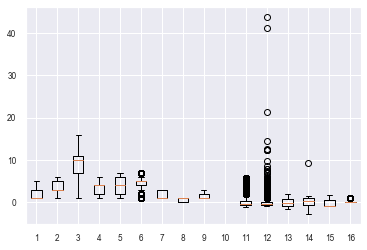

In [82]:
x1 = accept.V1
x2 = accept.V2
x3 = accept.V3
x4 = accept.V4
x5 = accept.V5
x6 = accept.V6
x7 = accept.V7
x8 = accept.Has_FICO
x9 = accept.Business_channel
#x10 = accept.Days_late
x11 = accept.FICO_Score
x12 = accept.Loan_amount
x13 = accept.Monthly_income
x14 = accept.Age
x15 = accept.Gearing_coefficient
x16 = accept.Max_gearing_ratio
x17 = accept.Default_45

#Plotting all the variables
plt.boxplot([x1,x2,x3,x4,x5,x6,x7,x8,x9,x11,x12,x13,x14,x15,x16,x17])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1316: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1323: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1331: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1332: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


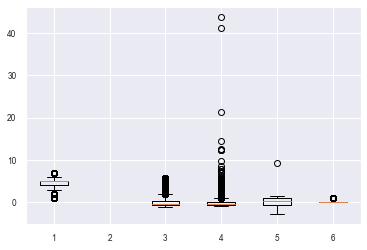

In [83]:
#plotting specific variables with outliers
plt.boxplot([x6,x11,x12,x13,x15,x17])
plt.show()

### WoE_Graphs

The graphs below show the relationship of information value of each variable and their categories with the target variable

In [21]:
import tkinter
import matplotlib
#import matplotlib.pyplot as plt
from xverse.graph import BarCharts

In [22]:
woe_df = clf.woe_df

In [23]:
grp = BarCharts(bar_type='v')

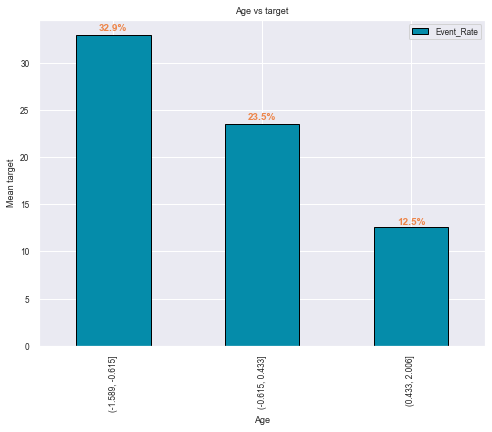

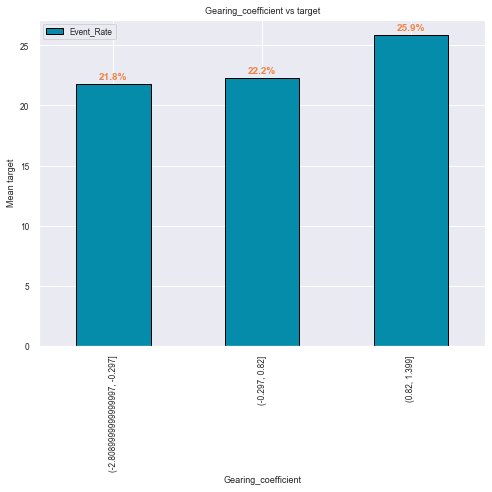

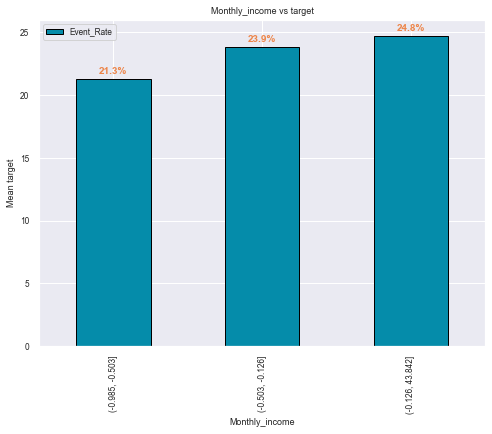

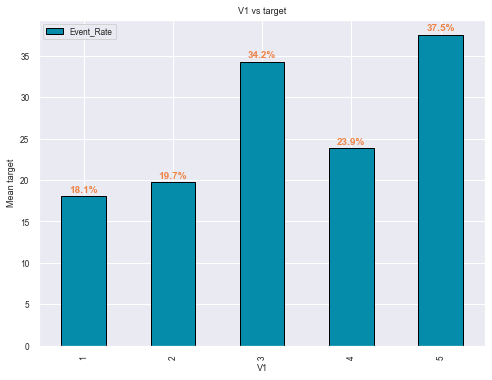

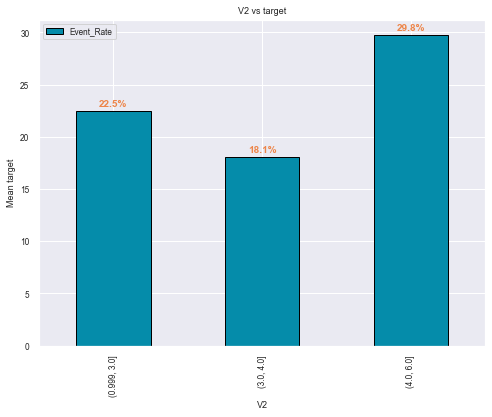

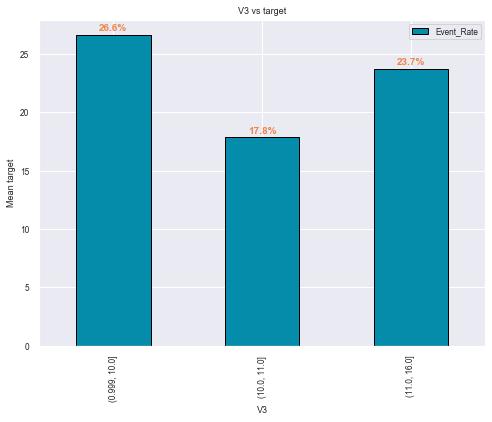

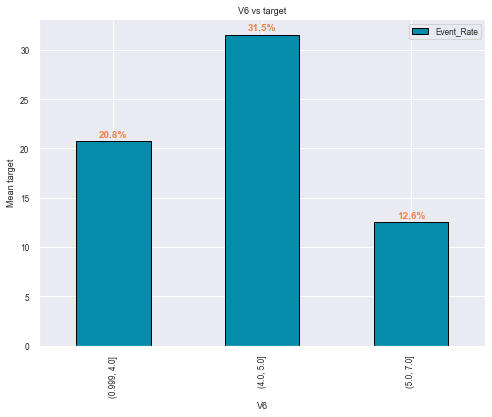

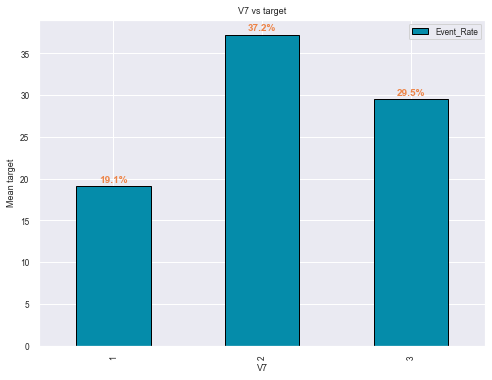

BarCharts(bar_color='#058caa', bar_type='v', exclude_features=None,
          feature_names='all', fig_size=(8, 6), num_color='#ed8549',
          plot_metric='mean')

In [24]:
%matplotlib inline
grp.plot(woe_df)

## Feature Importance

Now we check the importance of the features by measuring them with different methods like IV(WoE) , random forest, Recursive Feature Elimination, Extra Trees, Chi Square and L1. 
We take a sum of all the votes of each model and then subset the values on the basis of this score

In [25]:
from xverse.ensemble import VotingSelector

clf = VotingSelector()
clf.fit(X_train_Woe, y_train)

VotingSelector(exclude_features=None, feature_names='all',
               handle_category='woe', minimum_votes=0, no_of_features=8,
               numerical_missing_values='median',
               selection_techniques=['WOE', 'RF', 'RFE', 'ETC', 'CS', 'L_ONE'])

In [26]:
clf.feature_importances_


Variable_Name  Information_Value  Random_Forest  \
0            FICO_Score           0.651392       0.085918   
1                    V5           0.284045       0.051281   
2      Business_channel           0.268100       0.065085   
3                   Age           0.234751       0.063555   
4                    V6           0.176992       0.039974   
5                    V1           0.150433       0.054695   
6                    V4           0.118092       0.053239   
7                    V8           0.089621       0.071368   
8                    V7           0.088242       0.055191   
9                    V2           0.051817       0.079136   
10                   V3           0.051319       0.068382   
11          Loan_amount           0.017111       0.082899   
12             Has_FICO           0.010509       0.018731   
13  Gearing_coefficient           0.010220       0.089265   
14    Max_gearing_ratio           0.008024       0.053515   
15       Monthly_income           0.006752       0.067767   

    Recursive_Feature_Elimination  Extra_Trees  Chi_Square     L_One  
0                        0.789173     0.079505   87.011252  0.206499  
1                        0.612735     0.048684  100.724930  0.116788  
2                        0.977834     0.067357   34.273270  0.272552  
3                        0.000000     0.061638   70.495394  0.028276  
4                        0.000000     0.039916   41.457068  0.055586  
5                        0.000000     0.052680   86.211160  0.117797  
6                        0.000000     0.055836   21.422995  0.000000  
7                        0.549587     0.072535   48.761581  0.000000  
8                        0.000000     0.057097   39.478352  0.000000  
9                        0.871885     0.082299   14.606531  0.105596  
10                       0.000000     0.072507   17.156487  0.000000  
11                      -0.975733     0.081604    6.433654  0.000000  
12                       0.000000     0.020022    6.203666  0.000000  
13                       0.593575     0.086902    5.937120  0.000000  
14                       0.000000     0.052636    4.682269  0.000000  
15                       1.031327     0.068783    2.227139  0.000000

In [27]:
clf.feature_votes_

Variable_Name  Information_Value  Random_Forest  \
0            FICO_Score                  1              1   
2      Business_channel                  1              1   
7                    V8                  1              1   
1                    V5                  1              0   
9                    V2                  0              1   
3                   Age                  1              0   
4                    V6                  1              0   
5                    V1                  1              0   
11          Loan_amount                  0              1   
13  Gearing_coefficient                  0              1   
15       Monthly_income                  0              1   
6                    V4                  1              0   
10                   V3                  0              1   
8                    V7                  0              0   
12             Has_FICO                  0              0   
14    Max_gearing_ratio                  0              0   

    Recursive_Feature_Elimination  Extra_Trees  Chi_Square  L_One  Votes  
0                               1            1           1      1      6  
2                               1            1           1      1      6  
7                               1            1           1      0      5  
1                               1            0           1      1      4  
9                               1            1           0      1      4  
3                               0            0           1      1      3  
4                               0            0           1      1      3  
5                               0            0           1      1      3  
11                              1            1           0      0      3  
13                              1            1           0      0      3  
15                              1            1           0      0      3  
6                               0            0           0      1      2  
10                              0            1           0      0      2  
8                               0            0           1      0      1  
12                              0            0           0      0      0  
14                              0            0           0      0      0

After looking at the feature importance score, we choose a min cutoff value of 3

In [28]:
clf.minimum_votes = 3

In [29]:
X_train_new = clf.transform(X_train_Woe)
#reject_woe = clf.transform(reject_woe)

In [30]:
X_train_new.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
7913    0.109989         -0.178381 -0.299487  0.469706 -0.317099  0.012793   
4449   -1.978046          0.774912  0.012793 -0.385364 -0.317099  0.012793   
7691   -1.978046         -1.206447 -0.299487 -0.772246 -0.045223 -0.750304   
7614    0.109989         -0.178381 -0.299487  0.469706 -0.045223 -0.750304   
8479    0.109989         -0.178381 -0.273098 -0.772246 -0.045223  0.478301   

            V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  
7913  0.415886 -0.318978    -0.158983            -0.086551        0.030806  
4449  0.415886 -0.318978     0.000575            -0.059708       -0.114803  
7691 -0.147894 -0.318978     0.000575            -0.086551        0.079458  
7614  0.415886 -0.318978     0.000575            -0.086551        0.030806  
8479 -0.147894 -0.318978     0.157033            -0.086551        0.079458

In [31]:
#storing the cols of the train set for future use
features = list(X_train_new.columns)

### Applying WOE on test set

Now we apply the same woe bins on the test set before running the models

In [32]:
clf = WOE(woe_bins=output_woe_bins, mono_custom_binning=output_mono_bins,treat_missing='mode')

X_test_woe = clf.transform(X_test)
X_test_new = X_test_woe[features]

In [33]:
X_test_new.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
4429   0.992067         -0.178381  0.012793  0.469706  0.332289  0.478301   
5980   -1.97805         -0.178381 -0.299487  0.469706 -0.317099 -0.750304   
9148   -1.97805         -0.178381 -0.299487  0.469706 -0.317099 -0.750304   
5894   -1.97805         -0.178381  0.340704 -0.772246 -0.045223 -0.750304   
1597  -0.483605         -0.178381 -0.273098 -0.385364 -0.317099 -0.750304   

            V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  
4429  0.415886  0.538411    -0.158983             0.138343        0.030806  
5980  0.415886 -0.318978     0.000575             0.138343       -0.114803  
9148 -0.147894 -0.318978    -0.158983            -0.059708        0.030806  
5894 -0.747156  0.031748    -0.158983            -0.059708        0.079458  
1597 -0.147894 -0.318978     0.157033             0.138343        0.030806

### Comparing with different models

In this section we run the train and test set on different models and decide on the best one on basis of AUC and Accuracy

In [34]:
tree         = DecisionTreeClassifier()
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 500)
randomForest = RandomForestClassifier(n_estimators = 100,class_weight= 'balanced', criterion= 'entropy',
                                      max_depth= 7, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split= 18)
boostedTree  = GradientBoostingClassifier()
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [35]:
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from array import array

models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

for model in models:
    models[model].fit(X_train_new[features],y_train)
    print(f"{model} has been trained successfully")

performances = {}

for model in models:
    predictions   = models[model].predict(X_test_new)
    probabilities = DataFrame(models[model].predict_proba(X_test_new))[1]
    accuracy      = accuracy_score(y_test.tolist(),predictions)
    auc           = roc_auc_score(y_test,probabilities)
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

DataFrame(performances)

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


neuralNet has been trained successfully
neighbors has been trained successfully


tree  logistic  randomForest  boostedTree  neuralNet  neighbors
AUC       0.619594  0.735572      0.736501     0.737696   0.729031   0.675964
Accuracy  0.677500  0.763500      0.606000     0.743500   0.732500   0.705000

As we can see that the logistic regression is one of the best models that have been run on the train and test. 
Since it has a consistent performance on train and test and is easy to interpret. Hence we choose the logistic regression

### Training the logistic regression with more parameters and deriving probabilities

In [36]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [37]:
glmMod.fit(X_train_new, y_train)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [38]:
#score with test set
glmMod.score(X_test_new, y_test)

0.762

In [39]:
test_labels=glmMod.predict_proba(np.array(X_test_new.values))[:,1]

In [40]:
roc_auc_score(y_test,test_labels , average='macro', sample_weight=None)

0.7354337568443713

## Rejection Inference (Predicting on reject dataset)

It is an important step in credit scoring. 
So far, we’ve fit a logistic regression model. 
This entire process has looked at the current customer base which has mostly complete data and known credit (default or no default). 
However, applications for credit can often be missing a lot of data, which leads to a denial of credit. Denial of credit in this case is due to our biased model that only looks at complete records of people we know to be good or bad. We need to include some method to investigate the denials and include that information back into our model, so it is less bias and generalizes better.



In [41]:
reject = pd.read_excel("REJECTS.xlsx", sheet_name = 'Dataset')
ID_rej = reject['ID']
reject = reject.drop(columns=['ID'])
reject.head()

V1  V2  V3  V4  V5  V6  V7 V8  Has_FICO  Business_channel  FICO_Score  \
0   3   3  14   2   1   5   1  1         1                 1   -0.030455   
1   1   4   7   1   6   4   1  2         1                 1    0.715222   
2   1   4  10   4   5   4   1  4         1                 3    0.764933   
3   1   5  14   2   2   5   3  3         1                 1   -1.347818   
4   1   4  15   1   5   4   1  3         1                 2    1.634890   

   Loan_amount  Monthly_income       Age  Gearing_coefficient  \
0    -0.323920       -0.605449 -1.064220             1.028210   
1     5.668368        1.299572  0.807662             1.081778   
2    -0.750782        0.434027 -0.390342            -0.969416   
3    -0.852651       -0.490122 -0.989344             1.046303   
4     3.200955        0.561380  0.583036             0.088464   

   Max_gearing_ratio  
0          -0.768631  
1           1.796590  
2           1.796590  
3          -0.768631  
4           1.796590

In [42]:
reject = reject[features]

In [43]:
clf = WOE(woe_bins=output_woe_bins, mono_custom_binning=output_mono_bins,treat_missing='mode')

reject_woe = clf.transform(reject)


In [44]:
reject_woe.head()

FICO_Score  Business_channel        V8        V5  V2       Age        V6  \
0  -0.483605         -0.178381  0.340704  0.469706   3  0.478301  0.415886   
1   -1.97805         -0.178381 -0.299487 -0.772246   4 -0.750304 -0.147894   
2   -1.97805         -1.206447  0.012793 -0.385364   4  0.012793 -0.147894   
3   0.992067         -0.178381 -0.273098  0.469706   5  0.478301  0.415886   
4   -1.97805          0.774912 -0.273098 -0.385364   4 -0.750304 -0.147894   

         V1  Loan_amount  Gearing_coefficient  Monthly_income  
0  0.538411     0.000575             0.138343       -0.114803  
1 -0.318978     0.157033             0.138343        0.079458  
2 -0.318978    -0.158983            -0.086551        0.079458  
3 -0.318978    -0.158983             0.138343        0.030806  
4 -0.318978     0.157033            -0.059708        0.079458

In [45]:
predict_reject = glmMod.predict_proba(reject_woe[features])
predict2_reject= glmMod.predict(reject_woe[features])

In [46]:
proba= predict_reject[:,1]
reject['ID'] = ID_rej

Since this is a rejects database, we set a low threshold (40%) for a record to be set as default. This value can be changed on the basis of requirement of the company depending on their risk threshold

In [47]:
reject['Default_45'] = np.where(proba > 0.70, 1, 0)

### Joining training set with rejection set

Now we join the train set from earlier with the reject set to run a new model having better predictive bias that reduces the bias as explained earlier

In [48]:
X_train_V2 = X_train[features]

In [49]:
X_train_V2['Default_45'] = y_train
X_train_V2['ID']= ID_X_train

In [50]:
reject.head()

FICO_Score  Business_channel V8  V5  V2       Age  V6  V1  Loan_amount  \
0   -0.030455                 1  1   1   3 -1.064220   5   3    -0.323920   
1    0.715222                 1  2   6   4  0.807662   4   1     5.668368   
2    0.764933                 3  4   5   4 -0.390342   4   1    -0.750782   
3   -1.347818                 1  3   2   5 -0.989344   5   1    -0.852651   
4    1.634890                 2  3   5   4  0.583036   4   1     3.200955   

   Gearing_coefficient  Monthly_income      ID  Default_45  
0             1.028210       -0.605449  305932           1  
1             1.081778        1.299572  305764           0  
2            -0.969416        0.434027  305971           0  
3             1.046303       -0.490122  305664           1  
4             0.088464        0.561380  305639           0

In [51]:
X_train_V2.head()

FICO_Score  Business_channel V8  V5  V2       Age  V6  V1  Loan_amount  \
7913         NaN                 1  2   2   4 -0.240592   5   1    -0.852651   
4449    0.814645                 2  4   4   4  0.058909   5   1    -0.147676   
7691    1.411187                 3  2   6   1  0.508161   1   1    -0.209361   
7614         NaN                 1  2   2   3  0.657911   5   1    -0.323920   
8479         NaN                 1  3   6   2 -0.689843   4   1     1.614761   

      Gearing_coefficient  Monthly_income  Default_45      ID  
7913            -1.253575       -0.283879           0  298062  
4449             0.089528       -0.558870           0  280770  
7691            -0.451473        0.774385           0  296634  
7614            -0.731020       -0.499138           0  296762  
8479            -1.561147        3.156887           0  299627

In [52]:
New_df = pd.concat([X_train_V2, reject], ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


### Running Woe on New dataframe

In [53]:
ID_new = New_df['ID']
y_new = New_df['Default_45']
New_train = New_df[features]

In [54]:
clf = WOE()
clf.fit(New_train, y_new)

WOE(exclude_features=None, feature_names='all', mono_cardinality_cutoff=5,
    mono_custom_binning={'Age': array([-1.58834636, -0.61496811,  0.35841015,  2.08054091]),
                         'Business_channel': array([1., 2., 3.]),
                         'FICO_Score': array([-3.21201109, -0.60214124,  0.45423465,  2.46756282]),
                         'Gearing_coefficient': array([-2.86948406, -0.4298333 ,  0.75150115,  2.19996618]),
                         'Loan_amount': a...
                     Interval(5.0, 7.0, closed='right'): -1.1468274554020697},
              'V6': {Interval(0.999, 4.0, closed='right'): -0.18365684375173033,
                     Interval(4.0, 5.0, closed='right'): 0.5387068055463995,
                     Interval(5.0, 7.0, closed='right'): -1.205327801348657},
              'V8': {'1': 0.3519728842733606, '2': -0.37738353367442595,
                     '3': -0.18731623964606128, '4': 0.08704262174149047,
                     '>4': 0.5452841286869219}},
 

In [55]:
clf.woe_df.head()

Variable_Name          Category  Count  Event  Non_Event  Event_Rate  \
0               Age  (-1.589, -0.615]   3907   1554       2353    0.397748   
1               Age   (-0.615, 0.358]   3433   1063       2370    0.309642   
2               Age    (0.358, 2.081]   3660    624       3036    0.170492   
3  Business_channel                 1   8255   2424       5831    0.293640   
4  Business_channel                 2   1670    739        931    0.442515   

   Non_Event_Rate  Event_Distribution  Non_Event_Distribution       WOE  \
0        0.602252            0.479482                0.303261  0.458113   
1        0.690358            0.327985                0.305452  0.071177   
2        0.829508            0.192533                0.391288 -0.709174   
3        0.706360            0.747917                0.751514 -0.004798   
4        0.557485            0.228016                0.119990  0.642010   

   Information_Value  
0           0.223284  
1           0.223284  
2           0.223284  
3           0.244298  
4           0.244298

In [56]:
clf.iv_df

Variable_Name  Information_Value
2            FICO_Score           0.801743
8                    V5           0.417422
7                    V2           0.401040
9                    V6           0.329790
1      Business_channel           0.244298
0                   Age           0.223284
6                    V1           0.168656
10                   V8           0.107979
5        Monthly_income           0.035373
3   Gearing_coefficient           0.013483
4           Loan_amount           0.008183

In [57]:
New_train_woe = clf.transform(New_train)
New_train_woe.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
0   -0.179185         -0.004798 -0.377384  0.515385 -0.273692  0.071177   
1   -1.944778          0.642010  0.087043 -0.315689 -0.273692  0.071177   
2   -1.944778         -1.675070 -0.377384 -1.146827 -0.493939 -0.709174   
3   -0.179185         -0.004798 -0.377384  0.515385 -0.493939 -0.709174   
4   -0.179185         -0.004798 -0.187316 -1.146827 -0.493939  0.458113   

         V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  
0  0.538707 -0.305071    -0.117134            -0.135009        0.174820  
1  0.538707 -0.305071     0.097682            -0.020334       -0.267878  
2 -0.183657 -0.305071     0.097682            -0.135009        0.078240  
3  0.538707 -0.305071     0.097682            -0.135009       -0.267878  
4 -0.183657 -0.305071     0.029553            -0.135009        0.078240

In [58]:
output_woe_bins2 = clf.woe_bins #future transformation
output_mono_bins2 = clf.mono_custom_binning  #future transformation

### Applying new binning on validation set

In [59]:
clf = WOE(woe_bins=output_woe_bins2, mono_custom_binning=output_mono_bins2,treat_missing='mode')

X_valid_new = X_valid[features]
X_valid_woe = clf.transform(X_valid_new)
X_valid_woe.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
2818  0.0142554         -0.004798 -0.187316  0.515385 -0.493939  0.071177   
2239   -1.94478         -0.004798 -0.377384 -1.146827 -0.273692 -0.709174   
6092    1.31472         -0.004798  0.351973  0.515385 -0.493939  0.458113   
7141    1.31472         -0.004798 -0.187316  0.515385 -0.493939  0.458113   
3976  0.0142554         -0.004798 -0.377384  0.515385 -0.273692  0.458113   

            V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  
2818 -0.183657 -0.305071     0.029553            -0.135009        0.078240  
2239 -1.205328 -0.305071    -0.117134            -0.020334       -0.267878  
6092  0.538707  0.580728    -0.117134            -0.020334       -0.267878  
7141  0.538707 -0.305071     0.097682            -0.135009        0.078240  
3976 -0.183657 -0.305071     0.029553             0.147305       -0.267878

### Apply logistic regression on New_train_woe,y_new and  X_valid_woe , y_valid

In [60]:
glmMod = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
                            intercept_scaling=1, class_weight=None, 
                            random_state=None, solver='liblinear', max_iter=100,
                            multi_class='ovr', verbose=2)

In [61]:
glmMod.fit(New_train_woe, y_new)

[LibLinear]

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [62]:
#score with validation set
glmMod.score(X_valid_woe, y_valid)

0.7375

In [63]:
test_labels=glmMod.predict_proba(np.array(X_valid_woe.values))[:,1]

In [64]:
roc_auc_score(y_valid,test_labels , average='macro', sample_weight=None)

0.7363345610295223

# Scoring


There are a few extra steps required during the scorecard development if using Reject Inference:

Build a logistic regression model on the accepts (this is the base_logit_model.
Infer the rejects using a reject inference technique.
Combine the accepts and the inferred rejects into a single dataset (complete_population).
Build a new logistic regression model on complete_population (this is the final_logit_model).
Validate the final_logit_model.
Create a scorecard model based on the final_logit_model.




First, we collect the intercept value and coefficients from the logistic regression 

In [65]:
intercept = glmMod.intercept_[0]

In [66]:
coefficients = pd.DataFrame({"Feature":New_train_woe.columns.values,"Coefficients":np.transpose(glmMod.coef_[0, ])})


In [67]:
coefficients = coefficients.set_index('Feature')

In [68]:
scorecard = New_train_woe[coefficients.index].apply(lambda x: x*coefficients['Coefficients'].T,axis=1)

In [69]:
scorecard['logit'] = scorecard[list(scorecard.columns)].sum(axis=1) + intercept

In [70]:

# Convert Logit to Odds Ratio and Odds Ratio to Probability
scorecard['odds'] = np.exp(scorecard['logit'])
scorecard['probs'] = scorecard['odds'] / (scorecard['odds'] + 1)

In [71]:
# Set up Scoring Logic
target_score = 600
target_odds = New_df.loc[New_df['Default_45'] == 0].ID.count()/New_df.loc[New_df['Default_45'] == 1].ID.count()
pts_double_odds = 20

factor = pts_double_odds / np.log(2)
offset = target_score - factor * np.log(target_odds)

In [72]:
# Score
scorecard['score'] = offset + factor * scorecard['logit']

In [73]:
scorecard.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
0   -0.173096         -0.005461 -0.120030  0.291468 -0.345995 -0.009178   
1   -1.878691          0.730772  0.027685 -0.178533 -0.345995 -0.009178   
2   -1.878691         -1.906658 -0.120030 -0.648570 -0.624428  0.091442   
3   -0.173096         -0.005461 -0.120030  0.291468 -0.624428  0.091442   
4   -0.173096         -0.005461 -0.059578 -0.648570 -0.624428 -0.059070   

         V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  \
0  0.144488 -0.099788     0.186969            -0.138502        0.203192   
1  0.144488 -0.099788    -0.155920            -0.020860       -0.311353   
2 -0.049259 -0.099788    -0.155920            -0.138502        0.090937   
3  0.144488 -0.099788    -0.155920            -0.138502       -0.311353   
4 -0.049259 -0.099788    -0.047172            -0.138502        0.090937   

      logit      odds     probs       score  
0 -0.987615  0.372464  0.271383  546.314811  
1 -3.019057  0.048847  0.046572  487.699806  
2 -6.361151  0.001727  0.001724  391.267359  
3 -2.022862  0.132276  0.116823  516.443895  
4 -2.735671  0.064851  0.060901  495.876600

In [74]:
# Add Back the customer IDs and Target Feature Default_45
scorecard['customer_id'] = New_df['ID']
scorecard['target'] = New_df['Default_45']

In [75]:
# Remove Score Outliers (245, 0.156% of Total)
scorecard = scorecard[scorecard['score'] <= 600]

In [76]:

# Preview Score Data (Scores, Odds, Probs, etc)
scorecard.head()

FICO_Score  Business_channel        V8        V5        V2       Age  \
0   -0.173096         -0.005461 -0.120030  0.291468 -0.345995 -0.009178   
1   -1.878691          0.730772  0.027685 -0.178533 -0.345995 -0.009178   
2   -1.878691         -1.906658 -0.120030 -0.648570 -0.624428  0.091442   
3   -0.173096         -0.005461 -0.120030  0.291468 -0.624428  0.091442   
4   -0.173096         -0.005461 -0.059578 -0.648570 -0.624428 -0.059070   

         V6        V1  Loan_amount  Gearing_coefficient  Monthly_income  \
0  0.144488 -0.099788     0.186969            -0.138502        0.203192   
1  0.144488 -0.099788    -0.155920            -0.020860       -0.311353   
2 -0.049259 -0.099788    -0.155920            -0.138502        0.090937   
3  0.144488 -0.099788    -0.155920            -0.138502       -0.311353   
4 -0.049259 -0.099788    -0.047172            -0.138502        0.090937   

      logit      odds     probs       score  customer_id  target  
0 -0.987615  0.372464  0.271383  546.314811       298062       0  
1 -3.019057  0.048847  0.046572  487.699806       280770       0  
2 -6.361151  0.001727  0.001724  391.267359       296634       0  
3 -2.022862  0.132276  0.116823  516.443895       296762       0  
4 -2.735671  0.064851  0.060901  495.876600       299627       0

In [77]:
scorecard.score.mean()

528.021912130029

In [84]:
# Plot Distribution of Scores
plt.figure(figsize=(16,8))

plt.hist(scorecard['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

#plt.xlim(231,750)
plt.title('Scorecard Distribution', fontweight="bold", fontsize=14)
plt.axvline(scorecard['score'].mean(), color='k', linestyle='dashed', linewidth=1.5, alpha=0.5)
plt.text(470, 220, 'Mean Score: 528', color='red', fontweight='bold', style='italic', fontsize=10)
plt.xlabel('Score')
plt.ylabel('Count');

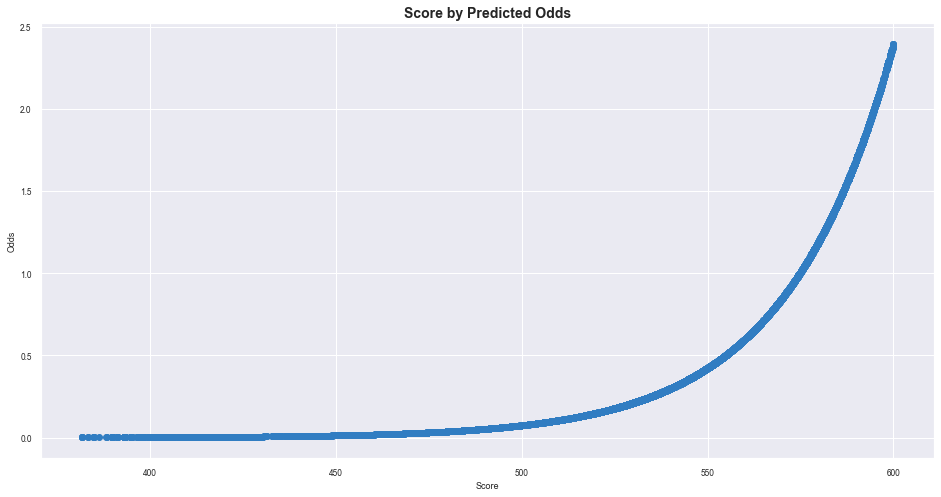

In [79]:
# Plot Scores Against Predicted Odds (Exponential Relationship)
plt.figure(figsize=(16,8))

plt.scatter(x='score',
            y='odds',
            data=scorecard,
            color='#317DC2')

plt.title('Score by Predicted Odds', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Odds');

Now, we can also see how those scores correlate to our probability of being good or bad credit customers for our business. The sigmoidal shape of the plot can be seem here

In [80]:
plt.figure(figsize=(16,8))

plt.scatter(x='score',
            y='probs',
            data=scorecard,
            color='#317DC2')

plt.title('Scores by Probability', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Probability (Good)');

Now, we divide the score range based on percentile 25, 50 and 75 into four divisions (Poor, Fair, Good and Excellent).

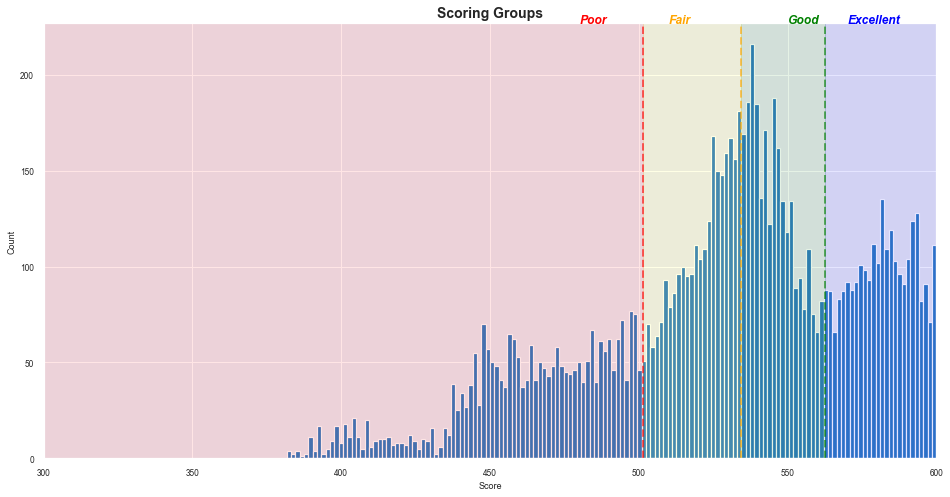

In [86]:
# Add Scoring Groups to Plot
plt.figure(figsize=(16,8))

plt.hist(scorecard['score'],
         bins=150,
         edgecolor='white',
         color = '#317DC2',
         linewidth=1.2)

plt.xlim(300,600)
plt.title('Scoring Groups', fontweight="bold", fontsize=14)
plt.xlabel('Score')
plt.ylabel('Count')

# Percentile Lines
plt.axvline(np.percentile(scorecard['score'],25), color='red', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(scorecard['score'],50), color='orange', linestyle='dashed', linewidth=2, alpha=0.6)
plt.axvline(np.percentile(scorecard['score'],75), color='green', linestyle='dashed', linewidth=2, alpha=0.6)

# Text
plt.text(480, 227, 'Poor', color='red', fontweight='bold', style='italic', fontsize=12)
plt.text(510, 227, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=12)
plt.text(550, 227, 'Good', color='green', fontweight='bold', style='italic', fontsize=12)
plt.text(570, 227, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=12)

# Shading between Percentiles
plt.axvspan(300, np.percentile(scorecard['score'],25), alpha=0.1, color='red')
plt.axvspan(np.percentile(scorecard['score'],25), np.percentile(scorecard['score'],50), alpha=0.1, color='yellow')
plt.axvspan( np.percentile(scorecard['score'],50), np.percentile(scorecard['score'],75), alpha=0.1, color='green')
plt.axvspan(np.percentile(scorecard['score'],75), 600, alpha=0.1, color='blue');

We can observe that maximum of the observations fall under the category of Fair and Good

Using the same Woe and logistic regression coefficient, scores can be calculated for new variables like demonstrated above.